# Bitcoin Data Analysis
*Bernhard Zosel, 15th December 2023*

### Imports

In [248]:
import numpy as np
import pandas as pd
import json

import networkx as nx

import matplotlib.pyplot as plt
import pygraphviz

import collections
import random

import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
import torch_geometric
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
import torch.nn as nn
import torch.optim as optim

## Data Import

*We are reading the parsed blockchain blocks and creating a dataframe with all relevant features, such as transaction id, the transaction ids of the inputs, the amounts of the outputs and the timestamp.*

In [2]:
# Path to JSON files
file_paths = ["outputs/tx00586.json", "outputs/tx00587.json","outputs/tx00588.json","outputs/tx00589.json","outputs/tx00590.json"]

# Initialize empty lists to store data
trans_ids = []
num_inputs = []
num_outputs = []
inputs = []
outputs = []
timestamps = []
total_values = []

# Open and read the JSON file line by line
for file_path in file_paths:
    with open(file_path, 'r') as file:
        for line in file:
            # Parse each line as a JSON object
            data = json.loads(line.strip())
    
            # Extract and append the necessary information
            trans_ids.append(data['txid'])
            
            num_inputs.append(len(data['tx_ins']))
            num_outputs.append(len(data['tx_outs']))
            
            timestamps.append(data['timestamp'])
            total_values.append(data['total_value'])
            
            # The input and output are lists of dictionaries, so convert them to string
            inputs.append([inp['hashPrevOut'] for inp in data['tx_ins']])
            outputs.append([out['value'] for out in data['tx_outs']])

# Create a DataFrame
df = pd.DataFrame({
    'trans_id': trans_ids,
    'num_input': num_inputs,
    'num_output': num_outputs,
    'input': inputs,
    'output': outputs,
    'timestamp': timestamps,
    'total_value': total_values
})

df

,trans_id,num_input,num_output,input,output,timestamp,total_value
0,0xd258b8b6bc885de05701d00f502feec549010610815d...,1,1,[0x],[1304275708],1470122456,1304275708
1,0xf5ae2ad8095c4a347adef38e7299a74df42099df2656...,1,7,[0x2266d8d615db7ba815c28ab60f3e31d16557bd87ac4...,"[5000000000, 5000000000, 104281776, 5000000000...",1470122456,30104281776
2,0x7ed98e51d8f520541389e7c45fcb9bf8d7c699b39620...,1,2,[0xc01dce720f88f4376fe69312a30367145c0eb09c3b7...,"[25406778, 4472667]",1470122456,29879445
3,0xe46a355f9fabb8af7bb34af9351d0016bcddf3b557ee...,2,2,[0x21e6b574a66d9d54c06fd017c84b40686d7b99331df...,"[149670000, 21613411]",1470122456,171283411
4,0xdff011e8721d26c4a5d6828864b4f5c64299ad1f3f9c...,1,2,[0xfeffd3688a77c3465c4d56c2d5e8a6282334e92dcc5...,"[62230000, 8037627805]",1470122456,8099857805
...,...,...,...,...,...,...,...
1257849,0xc24b3f1d48a662f9b6ff706a9c6b4cb584f619d781ea...,1,2,[0x44bbb180693dfd8bb6a4b9c4ca56644cb13a58a6bf4...,"[4150272, 49240248]",1470578622,53390520
1257850,0x855ffda8c3a5c927c81052d338850c69e004f2f3bb51...,1,2,[0xca1346fdeb31f9fa94528661034204a25ab975c2545...,"[4540000, 5026777]",1470578622,9566777
1257851,0xb65349eb0bc2de190fb603d7b5bc69e023d0f6cc3b2f...,1,2,[0xbe56a0b87a782eda11179b5226377383bffc77b2e20...,"[380000, 416569]",1470578622,796569
1257852,0xae241972123466e9f20554fe038ef9c8c131fe6939a1...,1,2,[0xb10cf5ffd95777cb4325c5a4161e7ed78f09f4e0c01...,"[5703312282, 50000000]",1470578622,5753312282


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.head(3)

,trans_id,num_input,num_output,input,output,timestamp,total_value
0,0xd258b8b6bc885de05701d00f502feec549010610815d...,1,1,[0x],[1304275708],2016-08-02 07:20:56,1304275708
1,0xf5ae2ad8095c4a347adef38e7299a74df42099df2656...,1,7,[0x2266d8d615db7ba815c28ab60f3e31d16557bd87ac4...,"[5000000000, 5000000000, 104281776, 5000000000...",2016-08-02 07:20:56,30104281776
2,0x7ed98e51d8f520541389e7c45fcb9bf8d7c699b39620...,1,2,[0xc01dce720f88f4376fe69312a30367145c0eb09c3b7...,"[25406778, 4472667]",2016-08-02 07:20:56,29879445


## Exploratorive Data Analysis (EDA)

### Transaction Frequency over analyzed time period

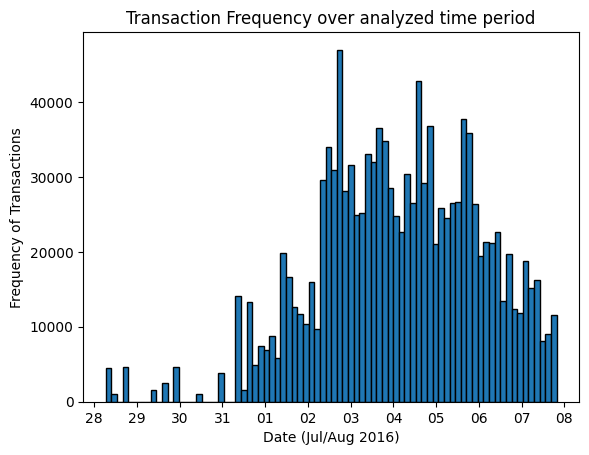

In [15]:
plt.hist(df['timestamp'], bins=80, edgecolor='black')
plt.title('Transaction Frequency over analyzed time period')
plt.xlabel('Date (Jul/Aug 2016)')
plt.ylabel('Frequency of Transactions')

plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))

plt.show()

### Input/Output Relationship

In [21]:
df_io = df[["num_input", "num_output"]].copy()
df_io["num_input"] = df_io["num_input"].apply(lambda x:5 if x>5 else x)
df_io["num_output"] = df_io["num_output"].apply(lambda x:5 if x>5 else x)
df_io.head()

,num_input,num_output
0,1,1
1,1,5
2,1,2
3,2,2
4,1,2


#### Number of outputs for a given number of inputs

In [22]:
result = df.groupby('num_input').agg(
    count=('num_input', 'size'),
    avg_num_output=('num_output', 'mean')
).reset_index()

total_count = result['count'].sum()
result['percentage'] = ((result['count'] / total_count) * 100).round(2)

result.iloc[0:10]

,num_input,count,avg_num_output,percentage
0,1,939987,2.422054,74.73
1,2,153851,2.342084,12.23
2,3,66006,2.610096,5.25
3,4,27528,3.341216,2.19
4,5,16125,3.176248,1.28
5,6,9857,2.994014,0.78
6,7,6647,3.212577,0.53
7,8,4780,3.555230,0.38
8,9,3499,3.404115,0.28
9,10,3123,4.086135,0.25


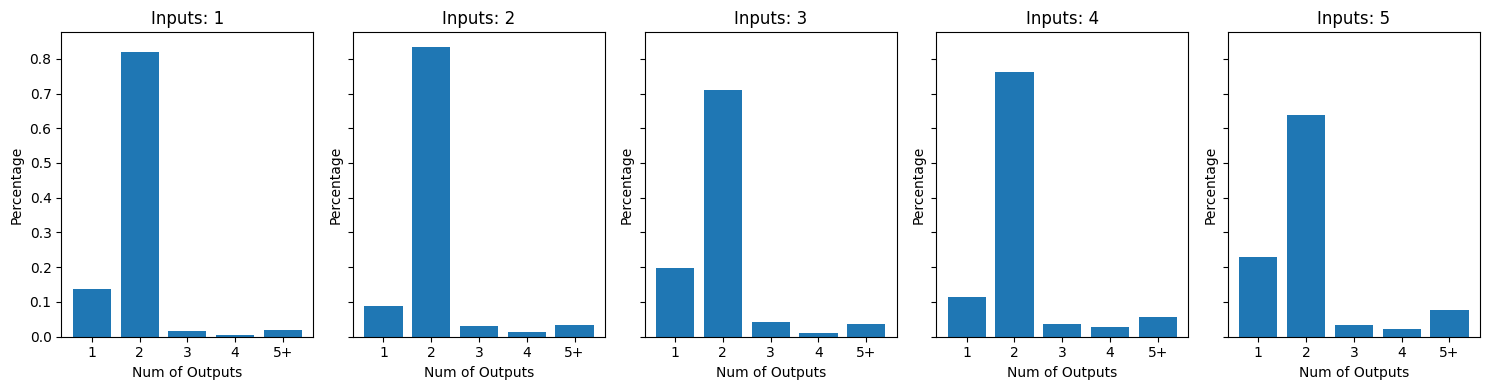

In [23]:
# Calculating relative percentages for the distribution of outputs for each input

# Group by 'num_inputs' and get value counts of 'num_outputs', normalize to get relative frequencies
grouped = df_io.groupby('num_input')['num_output'].value_counts(normalize=True).rename('percentage').reset_index()

# Plotting
fig, axs = plt.subplots(1, 5, figsize=(15, 4), sharey=True)

# Plot a histogram for each number of inputs (from 1 to 5) with relative frequencies
for i in range(1, 6):
    subset = grouped[grouped['num_input'] == i]
    subset = subset[subset["num_output"]<=5]
    axs[i - 1].bar(subset['num_output'], subset['percentage'], align='center')
    axs[i - 1].set_title(f'Inputs: {i}')
    axs[i - 1].set_xlabel('Num of Outputs')
    axs[i - 1].set_ylabel('Percentage')
    axs[i - 1].set_xticks(range(1, 6))
    axs[i - 1].set_xticklabels(['1', '2', '3', '4', '5+'])

plt.tight_layout()
plt.show()

*most transactions have 2 outputs, but the more inputs you have, the more likely is it that transactions have more than 2 outputs*

#### Number of inputs for a given number of outputs

In [26]:
result = df.groupby('num_output').agg(
    count=('num_output', 'size'),
    avg_num_input=('num_input', 'mean')
).reset_index()

total_count = result['count'].sum()
result['percentage'] = ((result['count'] / total_count) * 100).round(2)

result.iloc[0:10]

,num_output,count,avg_num_input,percentage
0,1,175563,5.221197,13.96
1,2,1011952,1.915728,80.45
2,3,26341,2.355719,2.09
3,4,10384,3.890697,0.83
4,5,6019,3.129257,0.48
5,6,5034,2.815852,0.40
6,7,2964,3.395412,0.24
7,8,2692,3.117756,0.21
8,9,2129,2.818694,0.17
9,10,1598,3.845432,0.13


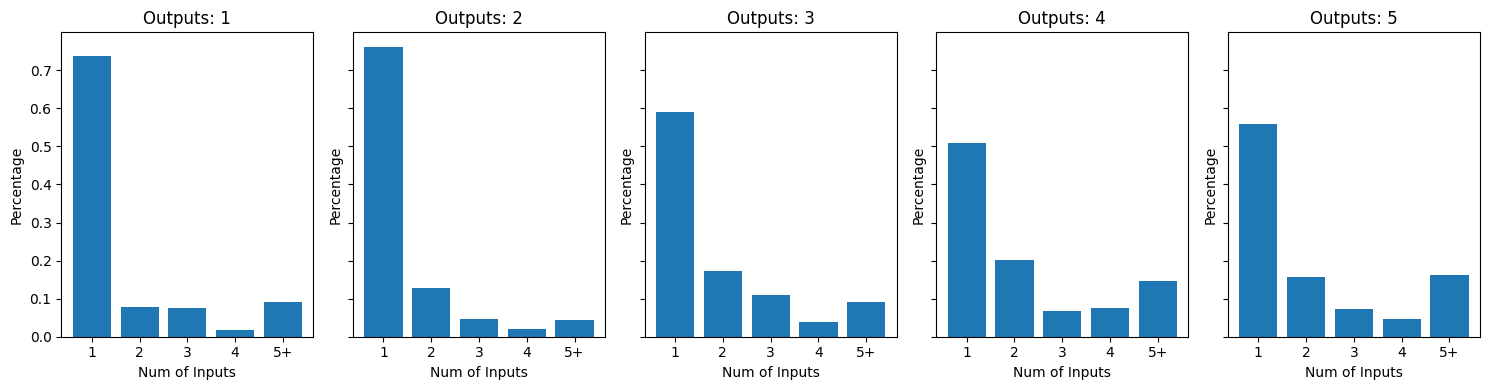

In [27]:
# Calculating relative percentages for the distribution of outputs for each input

# Group by 'num_inputs' and get value counts of 'num_outputs', normalize to get relative frequencies
grouped = df_io.groupby('num_output')['num_input'].value_counts(normalize=True).rename('percentage').reset_index()

# Plotting
fig, axs = plt.subplots(1, 5, figsize=(15, 4), sharey=True)

# Plot a histogram for each number of inputs (from 1 to 5) with relative frequencies
for i in range(1, 6):
    subset = grouped[grouped['num_output'] == i]
    subset = subset[subset["num_input"]<=5]
    axs[i - 1].bar(subset['num_input'], subset['percentage'], align='center')
    axs[i - 1].set_title(f'Outputs: {i}')
    axs[i - 1].set_xlabel('Num of Inputs')
    axs[i - 1].set_ylabel('Percentage')
    axs[i - 1].set_xticks(range(1, 6))
    axs[i - 1].set_xticklabels(['1', '2', '3', '4', '5+'])

plt.tight_layout()
plt.show()

*most transactions have 1 input but the more outputs a transaction has, the more inputs it usually has*

### Number of Input/Outputs for different transaction values

In [28]:
df_io = df[["num_input", "num_output", "total_value"]].copy()
df_io["total_value"] = df_io["total_value"].apply(lambda x:x/100000000) #convert amounts from sat to BTC
df_io.head()

,num_input,num_output,total_value
0,1,1,13.042757
1,1,7,301.042818
2,1,2,0.298794
3,2,2,1.712834
4,1,2,80.998578


/var/folders/11/br0wmdcn7gz_q71hct4883yw0000gn/T/ipykernel_36660/3823353071.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_io.groupby('total_value_bins').agg({'num_input': 'mean', 'num_output': 'mean', 'total_value': 'count'}).reset_index()


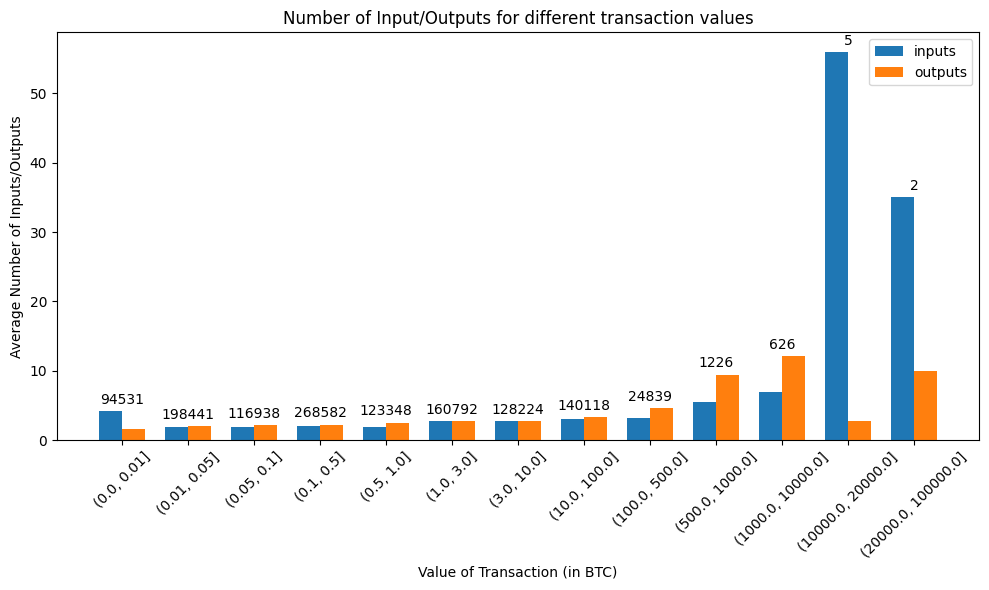

In [31]:
# Define bins for total_value
bins = np.array([0, 0.01, 0.05, 0.1, 0.5, 1, 3, 10, 100, 500, 1000, 10000, 20000, 100000])

# Grouping by total_value bins
df_io['total_value_bins'] = pd.cut(df_io['total_value'], bins)
grouped = df_io.groupby('total_value_bins').agg({'num_input': 'mean', 'num_output': 'mean', 'total_value': 'count'}).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar positions
bar_width = 0.35
index = np.arange(len(grouped))

# Plotting num_input and num_output averages side by side
bar1 = ax.bar(index, grouped['num_input'], bar_width, label='inputs')
bar2 = ax.bar(index + bar_width, grouped['num_output'], bar_width, label='outputs')

# Adding count annotations to each group of bars
for i in range(len(grouped)):
    ax.annotate(f'{grouped["total_value"][i]}',
                xy=(index[i] + bar_width / 2, max(grouped['num_input'][i], grouped['num_output'][i])),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Labels and Title
ax.set_xlabel('Value of Transaction (in BTC)')
ax.set_ylabel('Average Number of Inputs/Outputs')
ax.set_title('Number of Input/Outputs for different transaction values')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([str(bin) for bin in grouped['total_value_bins']])
ax.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


*Observation: small transactions (below 1 BTC) usually have few inputs and outputs but the larger the transaction, the larger both input and output gets, even though the average amount of outputs grow faster than the one of inputs*

*Note: for our period bewteen 2nd-8th August 2016 the price for 1 BTC was around 550-600 USD*

## Transaction Graph Construction

In [640]:
def visualize_graph(G, root=None):
    # Define colors for different types of nodes (root node is red, unrecorded nodes are grey and regular nodes are blue)
    color_map = []
    for node in G:
        if root!=None:
            if node==root:
                color_map.append('red')
                continue
        if G.nodes[node].get('type') == 'not_recorded':
            color_map.append('grey')  # Grey for not recorded nodes
        else:
            color_map.append('blue')  # Blue for recorded transactions
    
    # Draw the graph
    nx.draw(G, with_labels=False, node_color=color_map, pos=nx.drawing.nx_agraph.graphviz_layout(G, prog='dot'), node_size=80)

    # Show the plot
    plt.show()

#### Full Transaction Graphs Construction

*create a directed transaction graph where each node represents a transaction and edges connect transactions to its previous UXTOs*

*if previous transactions are not in our recorded time period, nevertheless add those transaction (with node type not_recorded)*

In [38]:
def create_transaction_graph(df):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges from the DataFrame
    for index, row in df.iterrows():
        trans_id = row['trans_id']
        amount = row['total_value']
        
        if trans_id in G: # Check if the input hash node already exists
            G.nodes[trans_id]['type'] = 'recorded'
            G.nodes[trans_id]['amount'] = amount
        else: 
            G.add_node(trans_id, type='recorded', amount=amount)

        for input_hash in row['input']:
            if input_hash in G:  # Check if the input hash node already exists
                G.add_edge(input_hash, trans_id)
            else:
                G.add_node(input_hash, type='not_recorded', amount=0) # set amount to 0 if the node has not been recorded
                G.add_edge(input_hash, trans_id)
    
    return G

In [39]:
graph = create_transaction_graph(df)
graph_undirected = graph.to_undirected()

*since we are only looking at a small part of the whole transaction graph, not every transaction can be connected to all previous UXTOs, therefore we create 'old_transaction' nodes instead. These nodes are, however, not further connected, i.e. they form the boundaries of our transaction graph.*

#### Exploratorive Data Analysis on Transaction Graphs

In [43]:
node_type_counts = collections.defaultdict(int)

# Iterate through nodes and count types
for _, node_data in graph.nodes(data=True):
    node_type = node_data.get('type', 'Unknown')  # Default to 'Unknown' if no type is set
    node_type_counts[node_type] += 1

# node_type_counts now contains the count of each node type
for t, x in node_type_counts.items():
    print(f"{t} : {x}")

recorded : 1257854
not_recorded : 849459


*we can see that of the 1.2 million transactions, 850k input transactions are missing*

In [57]:
nodes_missing_inputs = []
complete_txs = []

for node in graph.nodes():
    if graph.nodes[node].get('type') == 'recorded':
        not_missing = True
        for pred in graph.predecessors(node):
            if graph.nodes[pred]['type'] == 'not_recorded':
                nodes_missing_inputs.append(node)
                not_missing = False
                break
        if not_missing:
            complete_txs.append(node)

print("Transactions with not_recorded node as input:", len(nodes_missing_inputs))
print("Complete Transactions where all inputs have been recorded:", len(complete_txs))

Transactions with not_recorded node as input: 356926
Complete Transactions where all inputs have been recorded: 900928


*Because we are only looking at a limited timeframe, not every transaction's input transaction have been recorded in the dataset. In reality, only the inital transaction of every block would have no predecessor. We can see that 356926 of all 1.2 million transactions have **at least 1** input missing.*

We only consider complete transactions (complete_txs), since all inputs are defined for them.

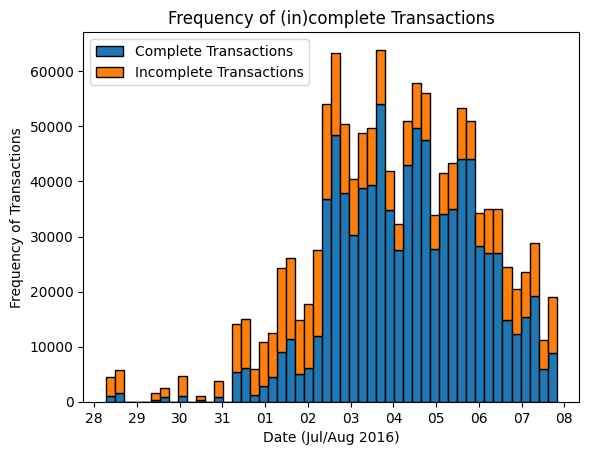

In [63]:
# Creating two sets of data for the histograms
data1 = df[df['trans_id'].isin(complete_txs)]['timestamp']
data2 = df[~df['trans_id'].isin(complete_txs)]['timestamp']

# Plotting stacked histograms
plt.hist([data1, data2], bins=50, edgecolor='black', stacked=True, label=['Complete Transactions', 'Incomplete Transactions'])

# Adding titles and labels
plt.title('Frequency of (in)complete Transactions')

plt.xlabel('Date (Jul/Aug 2016)')
plt.ylabel('Frequency of Transactions')

plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))

plt.legend()
plt.show()

we can see that especially the transactions that happen early in the recorded time window are more likely to be incomplete (i.e. their inputs are not recorded in the transaction graph). later in the time series there are relatively more complete transactions [...]*

#### Transaction Sub-Graph Construction

In [66]:
def subgraph_around_node(G, G_und, target_node, max_hops):
    # Find all nodes within max_hops from the target node    
    
    nodes_within_hops = set()

    # Function to add nodes within max_hops in a given direction
    def add_nodes_forward(node, current_hop):
        if current_hop <= max_hops:
            # Add the current node
            nodes_within_hops.add(node)
            # Recursively add successor/predecessor nodes
            for neighbor in G.successors(node):
                add_nodes_forward(neighbor, current_hop + 1)
    
    def add_nodes_backward(node, current_hop):
        if current_hop <= max_hops:
            # Add the current node
            nodes_within_hops.add(node)
            # Recursively add successor/predecessor nodes
            for neighbor in G.predecessors(node):
                add_nodes_backward(neighbor, current_hop + 1)

    add_nodes_forward(target_node, 0)
    add_nodes_backward(target_node, 0)

    # Create a subgraph with these nodes
    subgraph = G.subgraph(nodes_within_hops)
    return subgraph

*this method creates a subgraph for a single transaction by looking into the past (where the coins came from, from which transactions) and by looking into the future (which transactions further use the money)*

#### Test & Visualize Graph Construction

In [130]:
# pick random transaction
random_node = random.choice(df['trans_id'].values)
random_node

'0x99455f3ccc6db2461457de3c2c485b0d35bc139a16f7215caca2ee7280e743d7'

In [131]:
sg = subgraph_around_node(graph, graph_undirected, random_node, 2)
len(sg)

18

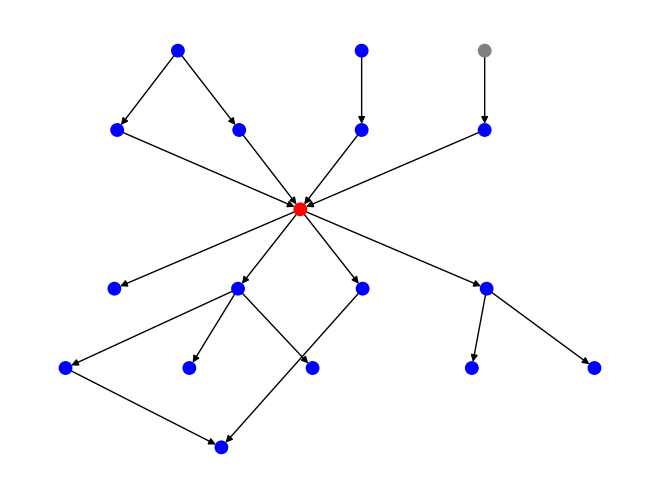

In [641]:
visualize_graph(sg, random_node)

*Example for tx_id '0x6fbefe466538456c16769da1776db0f27fa35692b4a9e6a30dd7daa63e90f1c2':*

*transaction gets two inputs and produces only one output, however, the coins from that output are then used in 6 following transactions*

#### Examine transaction graphs of high volume transactions

In [139]:
largest_transactions = df[df["total_value"]>100000000000]
len(largest_transactions)

633

In [135]:
largest_tx_graphs = []
for tx in largest_transactions["trans_id"]:
    largest_tx_graphs.append(subgraph_around_node(graph, graph_undirected,tx, 2))

In [140]:
# Graph Sizes
[len(g) for g in largest_tx_graphs][0:20]

[2, 2, 4, 17, 17, 7, 5, 9, 7, 395, 7, 12, 9, 25, 41, 9, 64, 15, 8, 7]

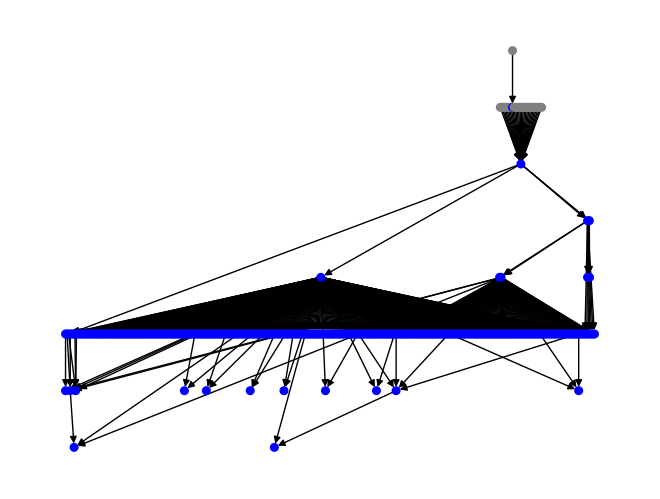

In [141]:
# visualize a graph with particularly many nodes
visualize_graph(largest_tx_graphs[9])

## Detection/Classification of suspicious Transactions

### Classification of Mixing vs. Regular Transactions

#### Import potential mixing transaction & label dataset

*load transaction ids extracted from walletexplorer.com which presumably belong to bitcoin mixing services*

*mixers.csv belongs to HelixMixer while mixers2.csv belongs to BitLaunder.com*

In [652]:
mixers = pd.read_csv("outputs/mixers.csv") #HelixMiner
mixers2 = pd.read_csv("outputs/mixers2.csv") #BitLaunder

def convert_txid(txid):
    return '0x' + txid

# Apply the function to the txid column to make them consistent with our transaction dataset
mixers['transaction'] = mixers['transaction'].apply(convert_txid)
mixers2['transaction'] = mixers2['transaction'].apply(convert_txid)

print(len(mixers))
print(len(mixers2))
mixers.head()

1545
888


,date,received from,received amount,sent amount,sent to,balance,transaction
0,2016-08-05 15:55:34,HelixMixer-old20 (00016f3b059e97c7),6.080000,NaN,NaN,6.080000,0xfe4cb153b326ce4a8da383dd9c5991c5a6c0f7a758bb...
1,2016-08-05 19:44:23,420ddbf52ed84a50,2.387209,NaN,NaN,33.363665,0x89252cd547424e8dec644e7e364ce24a0b83fca7dbd1...
2,2016-08-05 19:44:23,0d2a9bfa00a14419,0.558818,NaN,NaN,30.976457,0x190f84c5a9c35b557c15e5665e4f008276f4fd185b28...
3,2016-08-05 19:33:08,1243f727b7f70956,0.200000,NaN,NaN,30.417638,0x56ca888695c7409ab41f0bd853a8633d72e541892a19...
4,2016-08-05 19:23:45,db07e39e24acbcae,0.357921,NaN,NaN,30.217638,0x55e9785fc67a552ef085be2f0ed37f8edfeef92c48d9...


In [653]:
mixers_df = mixers[mixers["transaction"].isin(df["trans_id"].values)]
print(len(mixers_df))

mixers_df = mixers2[mixers2["transaction"].isin(df["trans_id"].values)]
print(len(mixers_df))

927
426


*not all transactions are part of our recorded bitcoin transactions only 926/1545 HelixMixer and 426/888 BitLaunder transactions*

In [654]:
highest_txs = df[df["total_value"]>60000000000]
len(highest_txs)

1356

*to start with a balanced dataset, we try to distinguish mixing transactions from the 1356 largest transactions of our dataset*

In [655]:
MAX_HOPS = 1 #determines how large the sub-graphs will be (depth=2*MAX_HOPS+1)

def create_mixers_dataset(balanced):
    mix_graphs = []
    # Helix
    for a in mixers["transaction"].values:
        if a in graph.nodes:
            mix_graphs.append(subgraph_around_node(graph, graph_undirected, a, MAX_HOPS))
    
    # BitcoinFog
    for a in mixers2["transaction"].values:
        if a in graph.nodes:
            mix_graphs.append(subgraph_around_node(graph, graph_undirected, a, MAX_HOPS))
    
    print(f"Number of Mixing Transactions: {len(mix_graphs)}")
    
    if balanced:
        for i in range(0,len(mix_graphs)):
            a = random.choice(df["trans_id"].values)
            if a in graph.nodes:
                mix_graphs.append(subgraph_around_node(graph, graph_undirected, a, MAX_HOPS))
    else:
        for i in range(0,10*len(mix_graphs)):
            a = random.choice(df["trans_id"].values)
            if a in graph.nodes:
                mix_graphs.append(subgraph_around_node(graph, graph_undirected, a, MAX_HOPS))


    return mix_graphs

mix_graphs_bal = create_mixers_dataset(balanced=True)
mix_graphs = create_mixers_dataset(balanced=False)

Number of Mixing Transactions: 1681
Number of Mixing Transactions: 1681


In [656]:
print(len(mix_graphs_bal))
print(len(mix_graphs))

3362
18491


In [657]:
# Create Labels for Graphs
mix_graphs_bal_y = ['Mixer'] * 1681 + ['Normal'] * (len(mix_graphs_bal)-1681)
print(len(mix_graphs_bal))
print(len(mix_graphs_bal_y))

mix_graphs_y = ['Mixer'] * 1681 + ['Normal'] * (len(mix_graphs)-1681)
print(len(mix_graphs))
print(len(mix_graphs_y))

3362
3362
18491
18491


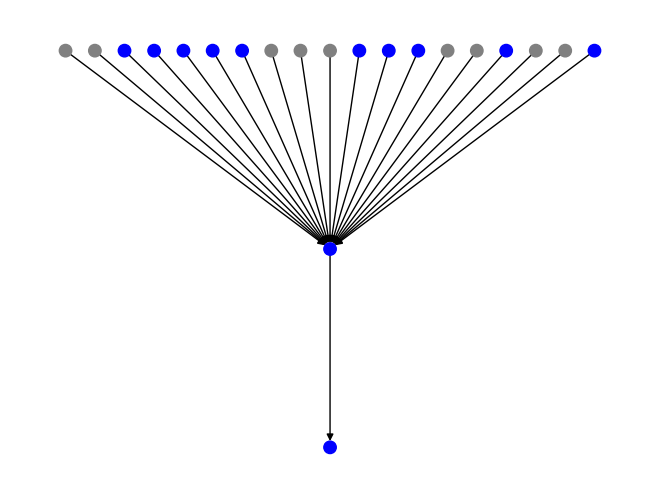

In [658]:
visualize_graph(mix_graphs[0])

#### Classification by considering easy graph features

In [573]:
def extract_features(graph):
    # Basic graph features
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    avg_in_degree = np.mean(list(dict(graph.in_degree()).values()))
    avg_out_degree = np.mean(list(dict(graph.out_degree()).values()))
    
    # More advanced features
    density = nx.density(graph)
    diameter = nx.diameter(graph.to_undirected()) if nx.is_connected(graph.to_undirected()) else None
    
    # Additional features based on node attributes (customize as needed)
    node_attributes = nx.get_node_attributes(graph, 'amount')
    avg_attribute_value = np.mean(list(node_attributes.values()))
    
    features = [num_nodes, num_edges, avg_in_degree, avg_out_degree, density, diameter, avg_attribute_value]
    
    return features

In [574]:
def train_and_test_classifier(clf, X_train, X_test, y_train, y_test):
    # Create and train a Random Forest classifier
    clf.fit(X_train, y_train)
    
    # Predict labels for the test set
    y_pred = clf.predict(X_test)
    
    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    cmd = ConfusionMatrixDisplay(conf_matrix, display_labels=['Mixer','Normal'])
    cmd.plot()

Accuracy: 0.6939078751857355


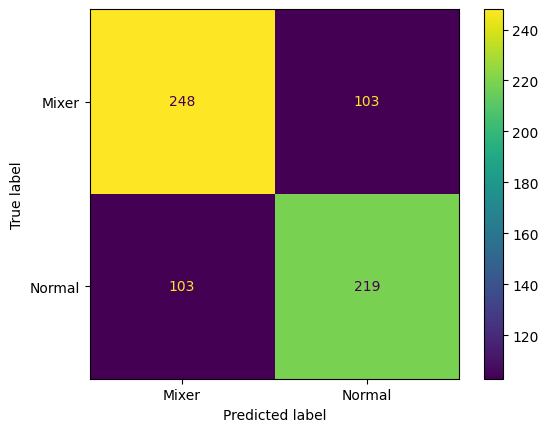

In [575]:
X_train, X_test, y_train, y_test = train_test_split(mix_graphs_bal, mix_graphs_bal_y, test_size=0.2, random_state=42)

# Extract graph features (e.g., number of nodes, average degree) from X_train and X_test
X_train_features = [extract_features(graph) for graph in X_train]
X_test_features = [extract_features(graph) for graph in X_test]

clf = RandomForestClassifier(criterion="entropy", max_depth=3, class_weight={'Normal': 1, 'Mixer': 1})
train_and_test_classifier(clf, X_train_features, X_test_features, y_train, y_test)

Accuracy: 0.8004866180048662


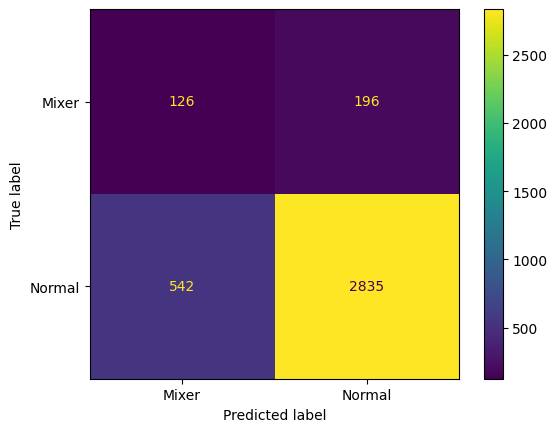

In [579]:
X_train, X_test, y_train, y_test = train_test_split(mix_graphs, mix_graphs_y, test_size=0.2, random_state=42)

# Extract graph features (e.g., number of nodes, average degree) from X_train and X_test
X_train_features = [extract_features(graph) for graph in X_train]
X_test_features = [extract_features(graph) for graph in X_test]

clf = RandomForestClassifier(criterion="entropy", max_depth=3, class_weight={'Normal': 1, 'Mixer': 7.5})
train_and_test_classifier(clf, X_train_features, X_test_features, y_train, y_test)

#### Classification with simple GNN model

*in order to input the data into the GNN, the nodes have to be labeled with numbers instead of trans_ids*

In [659]:
def transform_graph_str_int(original_graph):
    # Create mappings from string to numerical indices for nodes and edges
    node_to_index = {node: index for index, node in enumerate(original_graph.nodes())}
    index_to_node = {index: node for node, index in node_to_index.items()}
    
    # Create a new DiGraph with numerical indices
    numeric_graph = nx.DiGraph()
    
    # Add nodes to the new graph, retaining the 'amount' attribute
    for node, index in node_to_index.items():
        amount = original_graph.nodes[node].get('amount', 0)  # Default to 0 if 'amount' doesn't exist
        numeric_graph.add_node(index, amount=amount)
    
    # Add edges to the new graph using numerical indices
    for edge in original_graph.edges():
        source_index = node_to_index[edge[0]]
        target_index = node_to_index[edge[1]]
        numeric_graph.add_edge(source_index, target_index)

    return numeric_graph

# Applying the transformation to the list of graphs
#mix_graphs_num = [transform_graph_str_int(m) for m in mix_graphs]
mix_graphs_num = [transform_graph_str_int(m) for m in mix_graphs_bal]



In [660]:
# Define your GNN model
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Create a list to store graph embeddings
embeddings = []

# Initialize the GNN model
input_dim = 1  # Change this to match your input features
hidden_dim = 32  # You can adjust the hidden dimensions
output_dim = 8  # You can adjust the output dimensions
model = Net(input_dim, hidden_dim, output_dim)

# Iterate through the list of directed NetworkX graphs
for g in mix_graphs_num:
    # Convert the NetworkX graph to a PyTorch Geometric Data object
    edges = np.array(g.edges).T
    edge_index = torch.tensor(edges, dtype=torch.long)

    x = torch.tensor([g.nodes[node]['amount'] for node in g.nodes()], dtype=torch.float).unsqueeze(1)
    data = Data(x=x, edge_index=edge_index)
    
    # Compute node embeddings using the GNN model
    node_embeddings = model(data)
    
    # Compute graph-level embedding (e.g., mean pooling)
    graph_embedding = torch.mean(node_embeddings, dim=0)
    
    # Append the graph embedding to the list
    embeddings.append(graph_embedding.detach().numpy())

# Now, the 'embeddings' list contains the embedding vectors for the input graphs
len(embeddings)

3362

Accuracy: 0.7652303120356612


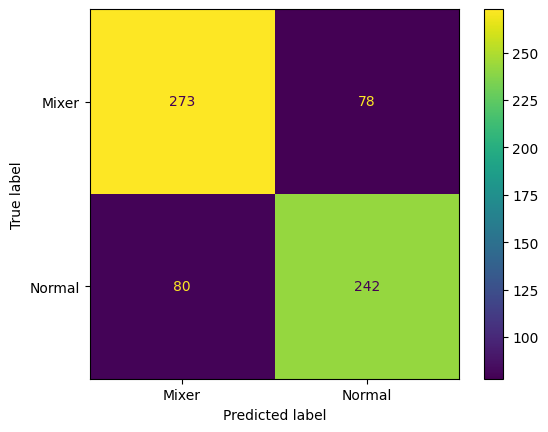

In [662]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, mix_graphs_bal_y, test_size=0.2, random_state=42)


# Create and train a Random Forest classifier
clf = RandomForestClassifier(criterion="entropy", max_depth=20)

train_and_test_classifier(clf, X_train, X_test, y_train, y_test)

## Anomaly Detection

### Anomaly Detection based on Full Graph Node Embeddings

*We sample a transaction graph with 100000 transactions and try to find anomolies in these subsequent transactions. We choose transactions in the middle of our recorded time period in order to get less incomplete transactions.*

In [631]:
graph_lim = create_transaction_graph(df.iloc[500000:600000])

node_to_index = {node: index for index, node in enumerate(graph_lim.nodes())}
index_to_node = {index: node for node, index in node_to_index.items()}

graph_lim_num = transform_graph_str_int(graph_lim)

print(len(graph_lim_num))

# Define your GNN model
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Create a list to store graph embeddings
embeddings = []

# Initialize the GNN model
input_dim = 1  # Change this to match your input features => curretly only consider value of transactions
hidden_dim = 8  # You can adjust the hidden dimensions
output_dim = 16  # You can adjust the output dimensions
model = Net(input_dim, hidden_dim, output_dim)

# Convert the NetworkX graph to a PyTorch Geometric Data object
edges = np.array(graph_lim_num.edges).T
edge_index = torch.tensor(edges, dtype=torch.long)

x = torch.tensor([graph_lim_num.nodes[node]['amount'] for node in graph_lim_num.nodes()], dtype=torch.float).unsqueeze(1)
x_standardized = (x - x.mean(0, keepdim=True)) / x.std(0, keepdim=True)
data = Data(x=x_standardized, edge_index=edge_index)

# Compute node embeddings using the GNN model
node_embeddings = model(data)

# Now, the 'embeddings' list contains the embedding vectors for the input graphs
print(len(node_embeddings))
node_embeddings

243056
243056


tensor([[-0.0336, -1.1237, -0.0175,  ..., -0.9521, -0.8613,  0.3608],
        [ 0.7462, -1.6379, -0.0388,  ..., -1.4584, -0.4226, -0.1483],
        [ 0.3758, -0.2333,  1.0415,  ...,  0.1130, -1.1808, -0.1516],
        ...,
        [ 0.0041,  0.0966,  0.1089,  ...,  0.0538, -0.1829, -0.2033],
        [ 0.0041,  0.0966,  0.1089,  ...,  0.0538, -0.1829, -0.2033],
        [ 0.2369, -0.2530,  0.3125,  ...,  0.1925, -0.5872, -0.3798]],
       grad_fn=<AddBackward0>)

*collect node embeddings of all 100.000 transactions*

In [632]:
emb = []
for n in df["trans_id"].iloc[500000:600000].values:
    nr = node_to_index[n]
    emb.append(node_embeddings[nr])
len(emb)

100000

In [633]:
embeddings = emb

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(True),
            nn.Linear(8, 4))
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(True),
            nn.Linear(8, 16))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)#, weight_decay=1e-5)

# Assuming embeddings is a list of numpy arrays or PyTorch tensors
embeddings = torch.stack([torch.tensor(e) for e in embeddings])

# Train the Model
num_epochs = 15  # Adjust as necessary
batch_size = 64  # Adjust based on your dataset size

for epoch in range(num_epochs):
    for i in range(0, len(embeddings), batch_size):
        batch = embeddings[i:i+batch_size]
        # Forward pass
        outputs = model(batch)
        loss = criterion(outputs, batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate Reconstruction Error
with torch.no_grad():
    reconstructed = model(embeddings)
    reconstruction_errors = torch.sum((embeddings - reconstructed) ** 2, dim=1).numpy()
    
    loss = criterion(reconstructed, embeddings)
    print(f'Mean Reconstruction Error: {loss.item()}')

    # Assuming a threshold (set based on your observations or statistical analysis)
    threshold = np.percentile(reconstruction_errors, 99.9)  # Example threshold
    anomalies = reconstruction_errors > threshold

# anomalies now contains a boolean array indicating which embeddings are considered anomalous

/var/folders/11/br0wmdcn7gz_q71hct4883yw0000gn/T/ipykernel_36660/1912126469.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.stack([torch.tensor(e) for e in embeddings])


Epoch [1/15], Loss: 21.5158
Epoch [2/15], Loss: 15.3057
Epoch [3/15], Loss: 10.5685
Epoch [4/15], Loss: 7.8123
Epoch [5/15], Loss: 5.9648
Epoch [6/15], Loss: 4.4247
Epoch [7/15], Loss: 3.3474
Epoch [8/15], Loss: 2.5248
Epoch [9/15], Loss: 1.8104
Epoch [10/15], Loss: 1.3395
Epoch [11/15], Loss: 0.9697
Epoch [12/15], Loss: 0.7706
Epoch [13/15], Loss: 0.5222
Epoch [14/15], Loss: 0.4294
Epoch [15/15], Loss: 0.3562
Mean Reconstruction Error: 0.0860024243593216


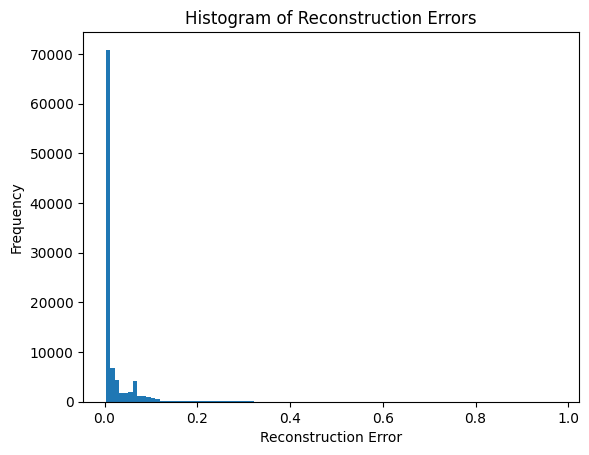

,trans_id,num_input,num_output,input,output,timestamp,total_value
500336,0xe61e77608a5bdaa7792aa1a88214bd7f9da64368e628...,2,2,[0x9a8dadab569a8cfbfa3590b6490a42f14ede27c5189...,"[499990000, 2009090000]",2016-08-04 10:11:09,2509080000
500567,0x870dc1f60ece8450a6f1bade63ad2124369d6e0d636d...,1,2,[0x3c8d3dfea970d22050a9903245b6b3b72ad372aef27...,"[84247787610, 215752086590]",2016-08-04 10:11:09,299999874200
500620,0xeaedeeff67eb35686ea09b156367dbc48ca02b18c8ff...,1,2,[0x870dc1f60ece8450a6f1bade63ad2124369d6e0d636...,"[36106194690, 179645879000]",2016-08-04 10:11:09,215752073690
501233,0xb2510d1e74840aa9559d9bf4604a97cbf0cc11419479...,187,1,[0x28cf4b71026ae6309a1e5ef260eaf47df3aba5102f8...,[6100000000],2016-08-04 10:17:33,6100000000
503846,0x81da1400bd421c47a6e3259dcd2146d54838a1ce824d...,53,2,[0xbb71a841bdeba834bb37ff31ddc82ed414d5550e5cd...,"[32400000000, 1000553]",2016-08-02 19:19:34,32401000553
...,...,...,...,...,...,...,...
596670,0xb5f6c409bcd3c8355ccfcbaff6a57c30df96cd96e545...,31,2,[0x69e5366c3d7c43bae1829f16bcfeb84fb79a514e5c3...,"[1000000000, 1000003]",2016-08-04 13:17:17,1001000003
598567,0x82f551d98550ee6bbc74de2197baf6a78523a4824522...,6,2,[0xac0d5fe3a6ebf73a29275f8fd11759f6cb8dad317c0...,"[17880000, 1000686]",2016-08-04 13:58:18,18880686
599266,0xedc27a282123e64bb40649e4b57d5559c97b362d4ca0...,356,1,[0xad9d04e5f3a5513a6657c79b20c19c2e04414298e50...,[345933813],2016-08-04 13:58:18,345933813
599832,0x9473bcce63ae522fb01c2e5e40a067fd93297b812bb3...,1,1,[0x6838d39624e06352b5005b7b0417679f5239b7d5171...,[199979680],2016-08-04 13:58:18,199979680


[ 471.64633 3532.273   2292.6492   793.50226  201.4298   204.46986
  165.22165  304.7819   233.18376  496.39664  179.93706 4909.587
  530.5308  2001.6847   227.2184   343.38403 1408.5122  3884.3782
  175.9904   201.35916  179.36803 1006.5514   168.05528  359.03522
  192.55309  211.57195  196.9725   458.12054  212.9905   356.59818
  352.70093  325.96854  382.84442  353.66614  337.74744  291.72208
  246.8252   534.3572   307.4977   743.6886   271.18     163.4278
  163.4278   163.4278   163.4278   163.4278   163.4278   163.4278
  163.4278   163.4278   249.25523  286.8588   656.7973  1330.2639
 1356.861    565.86255  256.78244  743.0698   817.8365   305.4624
  195.5623   448.5243  5466.106    285.5782   236.20099  200.98793
  586.25256  163.4278   163.4278   163.4278   163.4278   247.0378
 1409.3893   504.17365  163.4278   163.4278   163.4278  2343.1094
 1411.0476   442.98758  730.0732  1920.574    352.11243  241.33887
  272.2155   322.2384   264.66086  264.54193 2550.3123  2550.3123
 2550

In [644]:
# Analyze error distribution
plt.hist(reconstruction_errors_adj, bins=100)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.show()

display(df.iloc[500000:600000][anomalies])
print(reconstruction_errors[anomalies])

*even though most transactions have a relatively low reconstruction error close to 0, there are some with an exceptional high error.*

*We can see that they either have particularly high input/output ratios (e.g. 356 inputs to 1 output) or they have few inputs and outputs but have an exceptional high transaction value.*

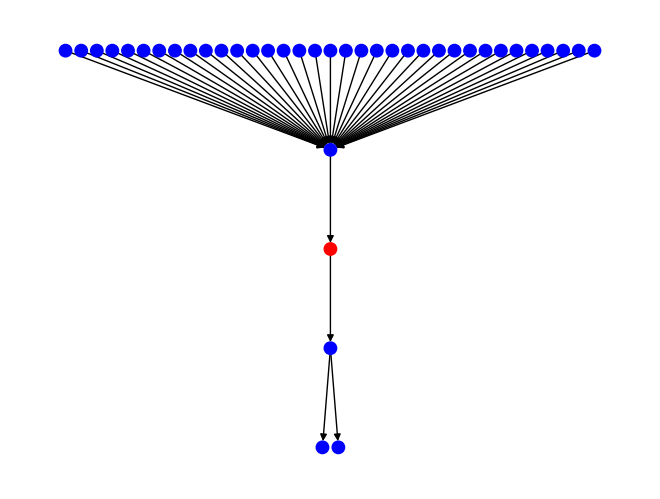

In [645]:
tx_id = df.iloc[500000:600000][anomalies]["trans_id"].iloc[-2]
visualize_graph(subgraph_around_node(graph, graph_undirected, tx_id, 2), tx_id)

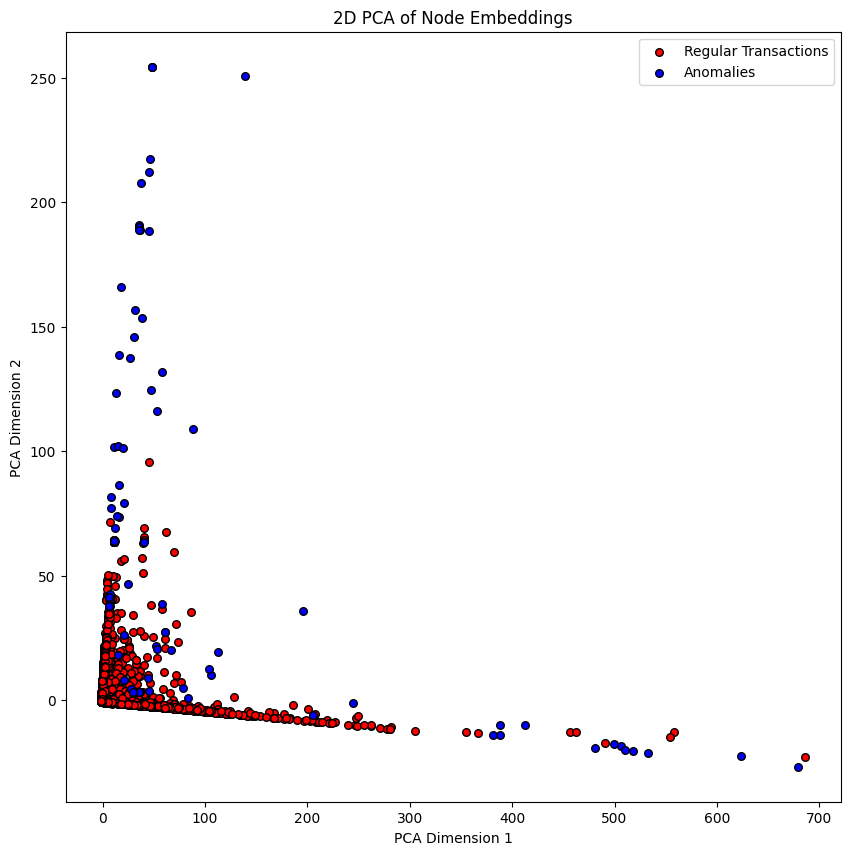

In [648]:
embeddings_matrix = torch.cat([emb.unsqueeze(0) for emb in embeddings], dim=0)
embeddings_matrix = embeddings_matrix.detach().numpy()

# Perform PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_matrix)

# Prepare color map based on anomalies
#color_map = np.where(anomalies, 'blue', 'red')

# Visualization
plt.figure(figsize=(10, 10))

regular_indices = np.where(anomalies == False)
plt.scatter(embeddings_2d[regular_indices, 0], embeddings_2d[regular_indices, 1], c='red', edgecolors='k', s=30, label='Regular Transactions')

# Plot Anomalies
anomaly_indices = np.where(anomalies == True)
plt.scatter(embeddings_2d[anomaly_indices, 0], embeddings_2d[anomaly_indices, 1], c='blue', edgecolors='k', s=30, label='Anomalies')

plt.title("2D PCA of Node Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

### Anomaly Detection based on sub-graph embeddings

*try to detect anomalies by examining the transaction sub-graphs for each transaction*

*the sub-graph embeddings are currently not properly working, with a different embedding method this should be comparable with the full graph embedding but should scale up better for bigger time periods and more transactions*

In [603]:
tx_graphs = []
tx_ids = []
#for tx in df["trans_id"][0:100000]:
for i in range(0,10000):
    tx = random.choice(df["trans_id"].values)
    tx_graphs.append(subgraph_around_node(graph, graph_undirected,tx, 4))
    tx_ids.append(tx)

In [604]:
# see how often transaction graphs have certain sizes
len_gra = []
for g in tx_graphs:
    len_gra.append(len(g))

from collections import Counter
Counter(len_gra)


Counter({9: 514,
         5: 483,
         2: 468,
         10: 461,
         12: 429,
         3: 423,
         6: 402,
         11: 372,
         7: 367,
         13: 358,
         4: 343,
         8: 330,
         14: 305,
         15: 283,
         16: 273,
         18: 269,
         17: 264,
         19: 227,
         20: 217,
         21: 167,
         22: 158,
         24: 141,
         25: 125,
         27: 123,
         23: 123,
         26: 109,
         28: 93,
         29: 85,
         31: 78,
         30: 75,
         33: 70,
         32: 67,
         34: 52,
         43: 48,
         40: 48,
         36: 46,
         35: 45,
         41: 40,
         37: 39,
         38: 38,
         39: 37,
         42: 34,
         51: 31,
         44: 30,
         59: 29,
         53: 29,
         45: 27,
         48: 27,
         50: 26,
         46: 26,
         52: 25,
         47: 24,
         49: 23,
         55: 23,
         60: 22,
         57: 21,
         58: 18,
         88: 

In [605]:
def transform_graph_str_int(original_graph):
    # Create mappings from string to numerical indices for nodes and edges
    node_to_index = {node: index for index, node in enumerate(original_graph.nodes())}
    index_to_node = {index: node for node, index in node_to_index.items()}
    
    # Create a new DiGraph with numerical indices
    numeric_graph = nx.DiGraph()
    
    # Add nodes to the new graph, retaining the 'amount' attribute
    for node, index in node_to_index.items():
        amount = original_graph.nodes[node].get('amount', 0)  # Default to 0 if 'amount' doesn't exist
        numeric_graph.add_node(index, amount=amount)
    
    # Add edges to the new graph using numerical indices
    for edge in original_graph.edges():
        source_index = node_to_index[edge[0]]
        target_index = node_to_index[edge[1]]
        numeric_graph.add_edge(source_index, target_index)

    return numeric_graph

# Applying the transformation to the list of graphs
tx_graphs_num = [transform_graph_str_int(m) for m in tx_graphs]

In [613]:
# Define your GNN model
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Create a list to store graph embeddings
embeddings = []

# Initialize the GNN model
input_dim = 1  # Change this to match your input features
hidden_dim = 8  # You can adjust the hidden dimensions
output_dim = 16  # You can adjust the output dimensions
model = Net(input_dim, hidden_dim, output_dim)

# Iterate through the list of directed NetworkX graphs
for g in tx_graphs_num:
    # Convert the NetworkX graph to a PyTorch Geometric Data object
    edges = np.array(g.edges).T
    edge_index = torch.tensor(edges, dtype=torch.long)
    
    x = torch.tensor([g.nodes[node]['amount'] for node in g.nodes()], dtype=torch.float).unsqueeze(1)
    #x = torch.tensor([0 for node in g.nodes()], dtype=torch.float).unsqueeze(1)
    x_standardized = (x - x.mean(0, keepdim=True)) / x.std(0, keepdim=True)
    #x = torch.randn(len(g.nodes), input_dim)
    data = Data(x=x_standardized, edge_index=edge_index)
    
    # Compute node embeddings using the GNN model
    node_embeddings = model(data)
    
    # Compute graph-level embedding (e.g., mean pooling)
    graph_embedding = torch.mean(node_embeddings, dim=0)
    
    # Append the graph embedding to the list
    embeddings.append(graph_embedding)

# Now, the 'embeddings' list contains the embedding vectors for the input graphs
print(len(embeddings))

10000


In [615]:
# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(True),
            nn.Linear(8, 4))
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(True),
            nn.Linear(8, 16))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)#, weight_decay=1e-5)

# Assuming embeddings is a list of numpy arrays or PyTorch tensors
embeddings = torch.stack([torch.tensor(e) for e in embeddings])

# Train the Model
num_epochs = 15  # Adjust as necessary
batch_size = 64  # Adjust based on your dataset size

for epoch in range(num_epochs):
    for i in range(0, len(embeddings), batch_size):
        batch = embeddings[i:i+batch_size]
        # Forward pass
        outputs = model(batch)
        loss = criterion(outputs, batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate Reconstruction Error
with torch.no_grad():
    reconstructed = model(embeddings)
    loss = criterion(reconstructed, embeddings)
    print(f'Mean Reconstruction Error: {loss.item()}')

    # Assuming a threshold (set based on your observations or statistical analysis)
    threshold = 0.1  # Example threshold
    anomalies = (torch.sum((embeddings - reconstructed) ** 2, dim=1) > threshold).numpy()

# anomalies now contains a boolean array indicating which embeddings are considered anomalous

/var/folders/11/br0wmdcn7gz_q71hct4883yw0000gn/T/ipykernel_36660/3639013467.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.stack([torch.tensor(e) for e in embeddings])


Epoch [1/15], Loss: 0.0174
Epoch [2/15], Loss: 0.0139
Epoch [3/15], Loss: 0.0094
Epoch [4/15], Loss: 0.0079
Epoch [5/15], Loss: 0.0074
Epoch [6/15], Loss: 0.0060
Epoch [7/15], Loss: 0.0053
Epoch [8/15], Loss: 0.0049
Epoch [9/15], Loss: 0.0046
Epoch [10/15], Loss: 0.0042
Epoch [11/15], Loss: 0.0037
Epoch [12/15], Loss: 0.0031
Epoch [13/15], Loss: 0.0022
Epoch [14/15], Loss: 0.0015
Epoch [15/15], Loss: 0.0011
Mean Reconstruction Error: 0.0009498666040599346


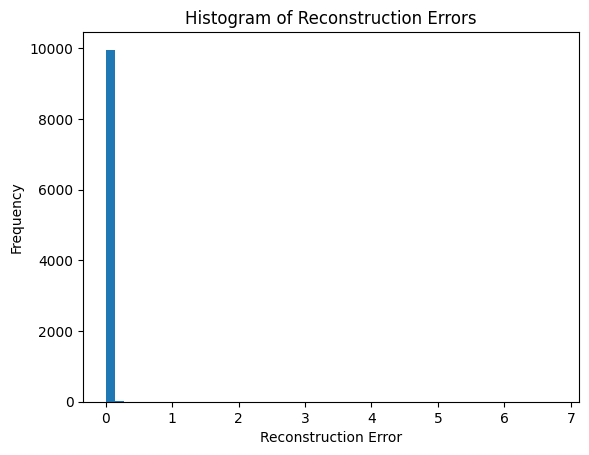

,trans_id,num_input,num_output,input,output,timestamp,total_value
4,0xdff011e8721d26c4a5d6828864b4f5c64299ad1f3f9c...,1,2,[0xfeffd3688a77c3465c4d56c2d5e8a6282334e92dcc5...,"[62230000, 8037627805]",2016-08-02 07:20:56,8099857805
39,0x6493c1e12b113e937a5b2868c9f4c1e96a7395455830...,1,2,[0x23c8a811ed272cea3b90a450c678eb0cb85c92ece22...,"[300000, 47354399]",2016-08-02 07:20:56,47654399
51,0xdbf0f3aa2f4ee9075f31668b71be7b3f2c0356165d57...,1,3,[0xf82c111bd75628b3b59827e6d6721ddc82aa6e82615...,"[90000000, 17587641837, 119261227]",2016-08-02 07:20:56,17796903064
62,0x46165354fb6beea86e6f931f4d0cca381bcbe47492c5...,1,2,[0xde0972300544fee58f2b36d65efa984b95b9e18029c...,"[2191952, 90314428]",2016-08-02 07:20:56,92506380
176,0x0c1ce0030b9b220da85fbe5dc2e4c5799ed54554379a...,1,2,[0xcef8fc326483ddf368f25cd134ae95e559fa9545460...,"[1693549, 6994472347]",2016-08-02 07:20:56,6996165896
...,...,...,...,...,...,...,...
9691,0x67a7d40297bc2f3569cb24d561e89495bd763c866d51...,2,2,[0x09650fed12d5e4fe98fbce82e09973f1acdc2872944...,"[183000, 25296900]",2016-07-29 15:31:40,25479900
9750,0xcf65c804af441b018c82a6cefa461fe90747190be235...,1,2,[0x3d8afece829a7918e32731f044e7bc401f93dc3b7b4...,"[2040700, 38410859]",2016-07-29 15:31:40,40451559
9912,0xc68f80a12d43592afc435a0b1f9f4558457410f25424...,1,2,[0xac14237e88d2a09f5510c8dd59fd5132eebdd01e902...,"[475000, 3416202240]",2016-07-29 15:31:40,3416677240
9926,0x1822ffdbe8f79a436d7f08cc3fc86a11bfe0fb6cca9b...,1,2,[0xe34c5a01733fc5261fd9e35019ffcbb013ff95179f4...,"[20000, 355816]",2016-07-29 15:31:40,375816


In [625]:
# Assuming embeddings and model from the previous example
with torch.no_grad():
    reconstructed = model(embeddings)
    reconstruction_errors = torch.sum((embeddings - reconstructed) ** 2, dim=1).numpy()

# Analyze error distribution
plt.hist(reconstruction_errors, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.show()

# Define a threshold
# Example: set the threshold as the 95th percentile of the reconstruction errors
threshold = np.percentile(reconstruction_errors, 99)

# Identify anomalies
anomalies = reconstruction_errors > threshold

# anomalies is a boolean array where True indicates an anomaly
anomalies
df.iloc[0:10000][anomalies]

In [626]:
tx_id = df.iloc[0:10000][anomalies]["trans_id"].iloc[5]
tx_id

'0x7ed7fb1f50bbe1ec6bf798d7dd020e85d06718784b177cd3b50f4635c850c5a3'

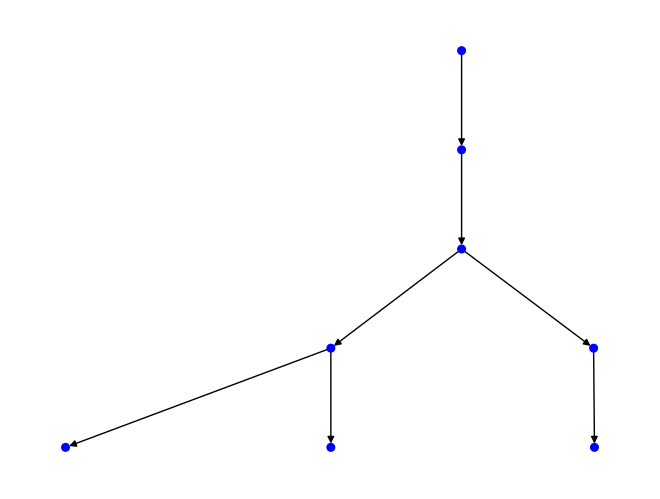

In [627]:
visualize_graph(subgraph_around_node(graph, graph_undirected, tx_id, 2))

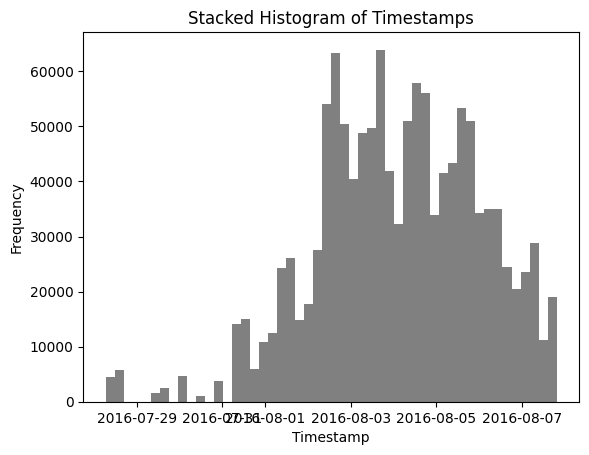

In [628]:
# Creating two sets of data for the histograms
data1 = df[df['trans_id'].isin(df.iloc[0:10000][anomalies]["trans_id"])]['timestamp']
data2 = df[~df['trans_id'].isin(df.iloc[0:10000][anomalies]["trans_id"])]['timestamp']

# Plotting stacked histograms
plt.hist([data1, data2], bins=50, stacked=True, color=["red", "grey"])

# Adding titles and labels
plt.title('Stacked Histogram of Timestamps')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')

# Show the plot
plt.show()

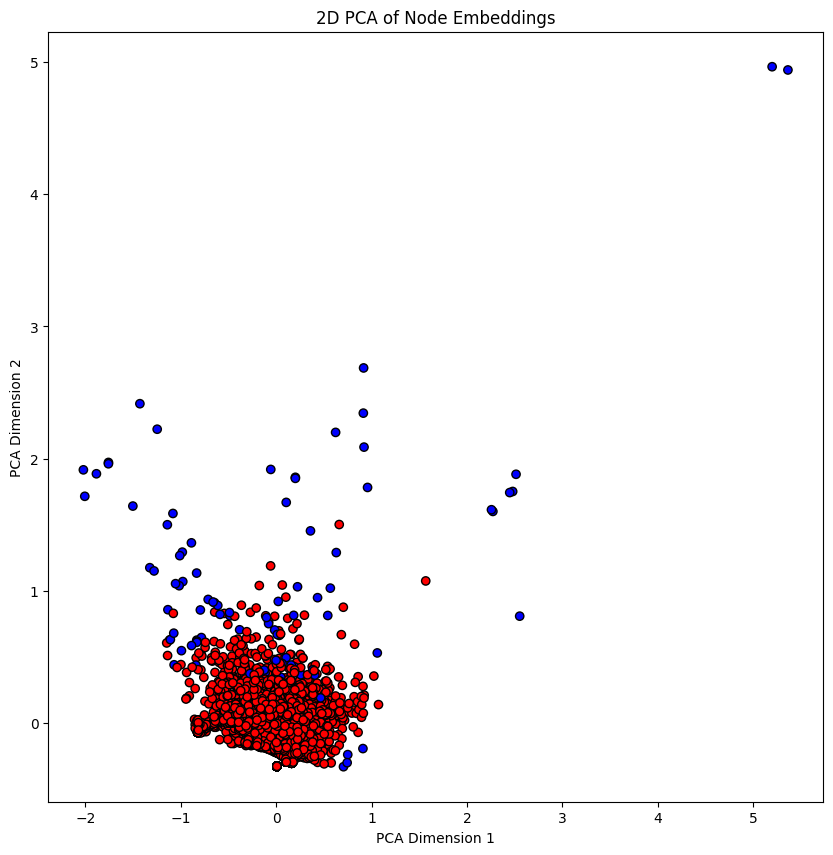

In [629]:
embeddings_matrix = torch.cat([emb.unsqueeze(0) for emb in embeddings], dim=0)
embeddings_matrix = embeddings_matrix.detach().numpy()

# Perform PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_matrix)

# Perform t-SNE dimensionality reduction
#tsne = TSNE(n_components=2, perplexity=5, n_iter=250)  # Adjust perplexity and n_iter as needed
#embeddings_2d = tsne.fit_transform(embeddings_matrix)

# Prepare color map based on anomalies
color_map = np.where(anomalies, 'blue', 'red')

# Visualization
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=color_map, edgecolors='k')  # s is the size of points
plt.title("2D PCA of Node Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()